# 12.1 Modulação por Código de Pulsos

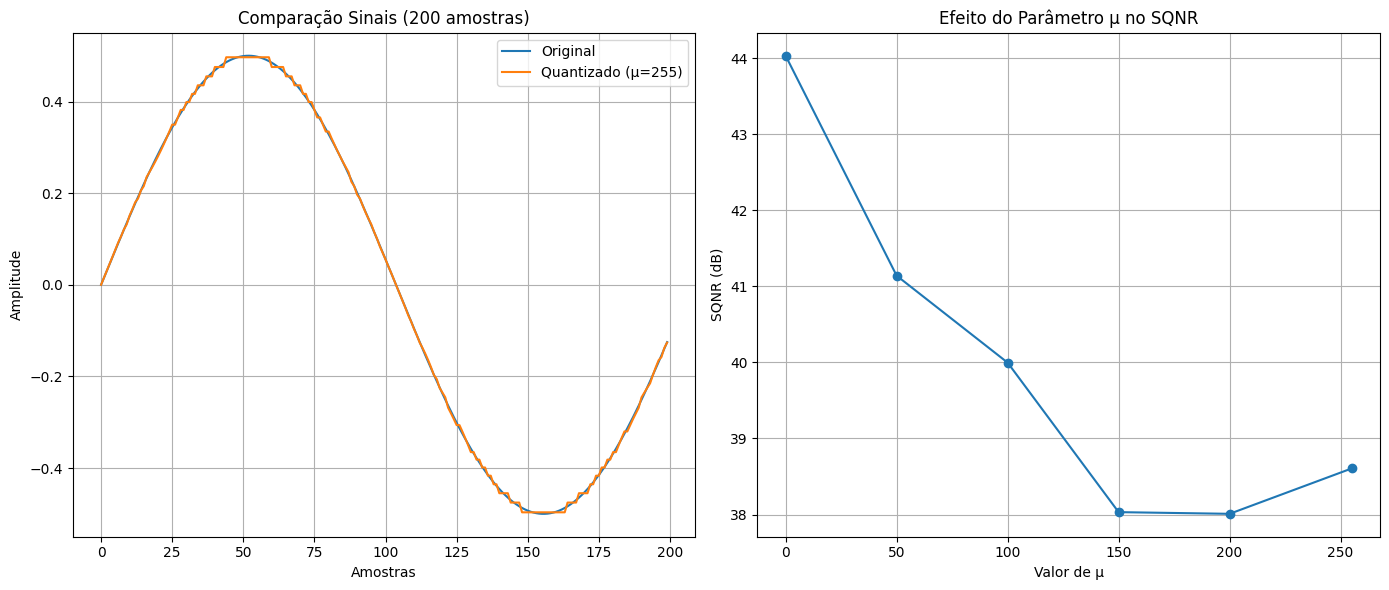


Resultados de SQNR para diferentes sinais:
Sinal        8 bits (µ=0)   8 bits (µ=255)   12 bits (µ=255) 
senoide      44.03          38.61            61.86           
serra        48.11          37.97            62.09           
exponencial  33.78          40.22            67.23           
ruído        39.00          37.91            61.95           


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import sawtooth

# 1. Compressor µ-law
def mu_law_compressor(s, mu=255):
    """Compressão não-linear do sinal"""
    # Handle mu=0 case for linear compression
    if mu == 0:
        return s
    return np.sign(s) * np.log1p(mu * np.abs(s)) / np.log1p(mu)

# 2. Quantizador Uniforme
def uniform_quantizer(x, b=8):
    """Quantização de b bits com saída normalizada"""
    x_normalized = (x + 1) / 2  # Mapeia para [0,1]
    quantized = np.round(x_normalized * (2**b - 1)) / (2**b - 1)
    return quantized * 2 - 1  # Mapeia de volta para [-1,1]

# 3. Expansor µ-law
def mu_law_expander(y, mu=255):
    """Expansão do sinal comprimido"""
    # Handle mu=0 case for linear expansion
    if mu == 0:
        return y
    return np.sign(y) * (1/mu) * ((1 + mu)**np.abs(y) - 1)

# 4. Cálculo do SQNR
def calculate_sqnr(original, quantized):
    """Calcula a relação sinal-ruído de quantização"""
    error = original - quantized
    # Add a small epsilon to the denominator to avoid division by zero if error is all zeros
    error_power = np.sum(error**2)
    if error_power == 0:
        return np.inf # Or a very large number
    return 10 * np.log10(np.sum(original**2) / error_power)


# Geração de sinais de teste
n = np.arange(10000)
signals = {
    'senoide': 0.5 * np.sin(n/33),
    'serra': sawtooth(n/50),
    'exponencial': 0.8**(n%100),
    'ruído': np.random.normal(0, 0.2, len(n))
}

# Processamento completo
def process_pcm(signal, b=8, mu=255):
    """Executa todo o pipeline PCM"""
    compressed = mu_law_compressor(signal, mu)
    quantized = uniform_quantizer(compressed, b)
    expanded = mu_law_expander(quantized, mu)
    return expanded, calculate_sqnr(signal, expanded)

# Análise para diferentes configurações
results = {}
for name, signal in signals.items():
    results[name] = {
        '8bit_µ0': process_pcm(signal, b=8, mu=0),
        '8bit_µ255': process_pcm(signal, b=8, mu=255),
        '12bit_µ255': process_pcm(signal, b=12, mu=255)
    }

# Visualização dos resultados
plt.figure(figsize=(14, 6))

# Gráfico 1: Comparação de formas de onda
plt.subplot(1, 2, 1)
original_signal = signals['senoide'][:200]
processed_signal = results['senoide']['8bit_µ255'][0][:200]
plt.plot(original_signal, label='Original')
plt.plot(processed_signal, label='Quantizado (µ=255)')
plt.title('Comparação Sinais (200 amostras)')
plt.xlabel('Amostras')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)

# Gráfico 2: SQNR vs Parâmetro µ
plt.subplot(1, 2, 2)
mu_values = [0, 50, 100, 150, 200, 255]
sqnr_values = [process_pcm(signals['senoide'], b=8, mu=mu)[1] for mu in mu_values]
plt.plot(mu_values, sqnr_values, marker='o')
plt.title('Efeito do Parâmetro µ no SQNR')
plt.xlabel('Valor de µ')
plt.ylabel('SQNR (dB)')
plt.grid(True)

plt.tight_layout()
plt.show()

# Tabela de resultados
print("\nResultados de SQNR para diferentes sinais:")
print(f"{'Sinal':<12} {'8 bits (µ=0)':<14} {'8 bits (µ=255)':<16} {'12 bits (µ=255)':<16}")
for name in signals:
    sqnrs = results[name]
    print(f"{name:<12} {sqnrs['8bit_µ0'][1]:<14.2f} {sqnrs['8bit_µ255'][1]:<16.2f} {sqnrs['12bit_µ255'][1]:<16.2f}")

# 12.2 PCM Diferencial

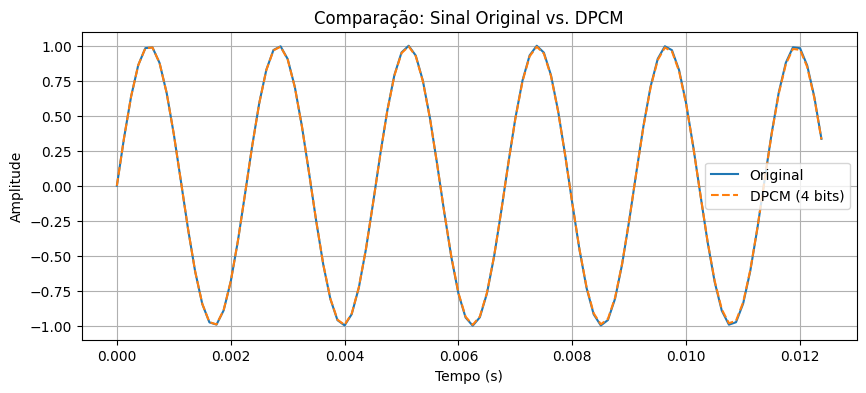

In [2]:
import numpy as np
from scipy.linalg import toeplitz

def dpcm_predictor(signal, p=2):
    """Calcula os coeficientes do preditor linear."""
    N = len(signal)

    # Autocorrelação
    r = np.zeros(p + 1)
    for i in range(p + 1):
        r[i] = np.sum(signal[i:] * signal[:N - i])

    # Resolve sistema R . a = r
    R = toeplitz(r[:p])
    a = np.linalg.solve(R, r[1:p+1])

    return a

def dpcm_encode(signal, bits=4, p=2):
    """Codifica o sinal usando DPCM."""
    a = dpcm_predictor(signal, p)
    N = len(signal)
    quantized_errors = np.zeros(N)
    reconstructed = np.zeros(N)

    # Inicializa com as primeiras p amostras (sem codificação)
    reconstructed[:p] = signal[:p]

    # Quantização
    max_error = np.max(np.abs(signal))
    delta = (2 * max_error) / (2 ** bits)

    for n in range(p, N):
        # Predição
        prediction = np.sum(a * reconstructed[n - p:n][::-1])
        error = signal[n] - prediction

        # Quantização (simples)
        quantized = int(np.round((error + max_error) / delta))
        quantized = np.clip(quantized, 0, 2 ** bits - 1)
        quantized_errors[n] = quantized

        # Reconstrução (para feedback)
        reconstructed[n] = prediction + (quantized * delta - max_error)

    return quantized_errors.astype(int), a

def dpcm_decode(quantized_errors, a, bits=4, initial_samples=None):
    """Decodifica o sinal DPCM."""
    p = len(a)
    N = len(quantized_errors)
    reconstructed = np.zeros(N)

    if initial_samples is not None:
        reconstructed[:p] = initial_samples[:p]

    max_error = np.max(np.abs(initial_samples)) if initial_samples is not None else 1.0
    delta = (2 * max_error) / (2 ** bits)

    for n in range(p, N):
        prediction = np.sum(a * reconstructed[n - p:n][::-1])
        error = quantized_errors[n] * delta - max_error
        reconstructed[n] = prediction + error

    return reconstructed

# Exemplo de uso
fs = 8000  # Taxa de amostragem
t = np.linspace(0, 1, fs)
signal = np.sin(2 * np.pi * 440 * t)  # Sinal de teste (440 Hz)

# Codifica e decodifica
quantized, a = dpcm_encode(signal, bits=4, p=2)
decoded = dpcm_decode(quantized, a, bits=4, initial_samples=signal[:2])

# Plot
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(t[:100], signal[:100], label="Original")
plt.plot(t[:100], decoded[:100], label="DPCM (4 bits)", linestyle="--")
plt.legend()
plt.title("Comparação: Sinal Original vs. DPCM")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.show()

# 12.3 PCM e DPCM adaptativos (ADPCM)

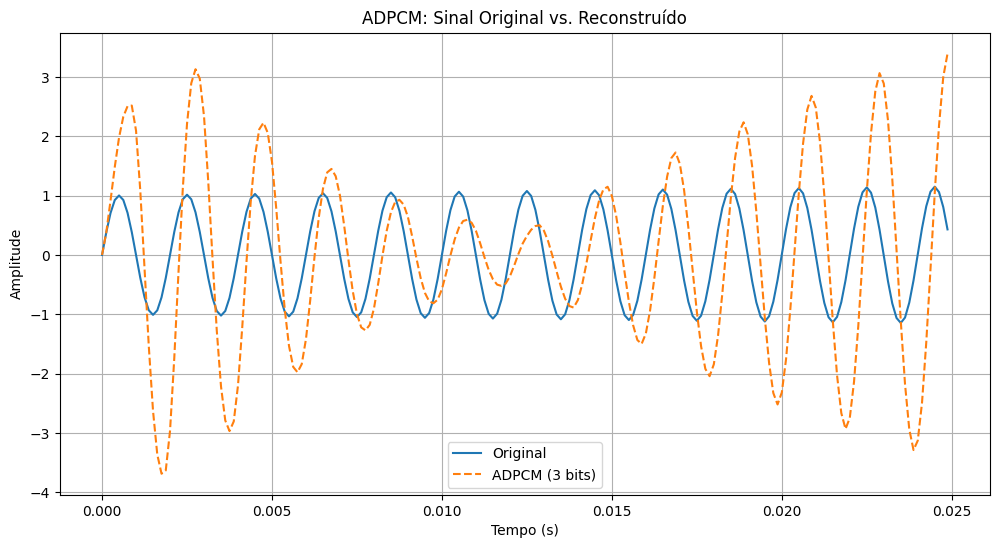

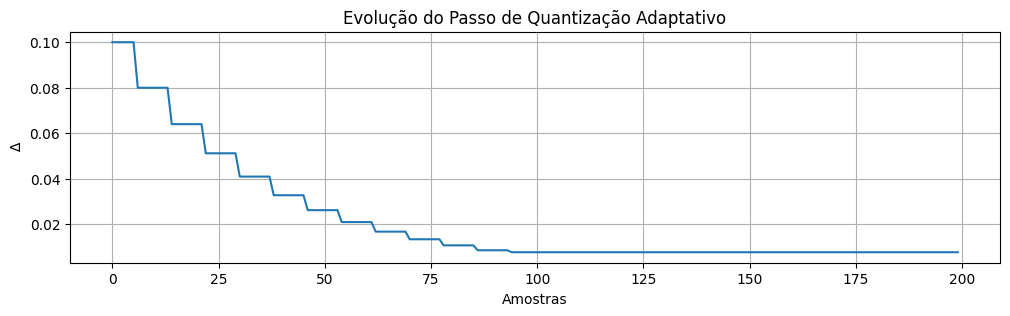

In [3]:
# Fatores de multiplicação M(n) para quantizador de 3 bits (exemplo)
M_TABLE = {
    0: 0.8,   # Nível baixo: reduz ∆
    1: 0.9,
    2: 0.95,
    3: 1.0,   # Nível médio: mantém ∆
    4: 1.0,
    5: 1.05,
    6: 1.1,
    7: 1.5    # Nível alto: aumenta ∆
}

def adpcm_quantizer(signal, bits=3, initial_delta=0.1):
    """Quantizador ADPCM com adaptação por feedback."""
    quantized = np.zeros(len(signal), dtype=int)
    delta = initial_delta
    deltas = [delta]

    for n in range(len(signal)):
        # Quantiza o sinal
        level = int(np.round(signal[n] / delta))
        level = np.clip(level, -2**(bits-1), 2**(bits-1)-1)
        quantized[n] = level

        # Atualiza delta (usando valor absoluto do nível)
        delta *= M_TABLE.get(abs(level), 1.0)
        deltas.append(delta)

    return quantized, deltas

def adpcm_encode(signal, pred_order=2, bits=3):
    """Codificador ADPCM com preditor e quantizador adaptativos."""
    # Inicialização
    N = len(signal)
    a = np.zeros(pred_order)  # Coeficientes do preditor
    reconstructed = np.zeros(N)
    quantized, deltas = [], []
    delta = 0.1  # Passo inicial

    for n in range(pred_order, N):
        # Predição (usando amostras reconstruídas)
        prediction = np.sum(a * reconstructed[n-pred_order:n][::-1])
        error = signal[n] - prediction

        # Quantização adaptativa
        level = int(np.round(error / delta))
        level = np.clip(level, -2**(bits-1), 2**(bits-1)-1)
        quantized.append(level)

        # Atualiza delta (feedback)
        delta *= M_TABLE.get(abs(level), 1.0)
        deltas.append(delta)

        # Reconstrução para feedback
        reconstructed[n] = prediction + level * delta

        # Atualiza preditor (simplificado - autocorrelação em blocos)
        if n % 100 == 0:  # Atualiza a cada 100 amostras
            window = reconstructed[n-99:n+1]
            r = np.array([np.sum(window[i:] * window[:len(window)-i]) for i in range(pred_order+1)])
            R = toeplitz(r[:pred_order])
            a = np.linalg.solve(R, r[1:pred_order+1])

    return np.array(quantized), deltas, a

def adpcm_decode(quantized, deltas, a, initial_samples):
    """Decodificador ADPCM."""
    pred_order = len(a)
    N = len(quantized) + pred_order
    reconstructed = np.zeros(N)
    reconstructed[:pred_order] = initial_samples[:pred_order]

    for n in range(pred_order, N):
        # Predição
        prediction = np.sum(a * reconstructed[n-pred_order:n][::-1])
        # Reconstrução do erro
        error = quantized[n-pred_order] * deltas[n-pred_order]
        reconstructed[n] = prediction + error

        # Atualiza preditor periodicamente (como no codificador)
        if n % 100 == 0:
            window = reconstructed[n-99:n+1]
            r = np.array([np.sum(window[i:] * window[:len(window)-i]) for i in range(pred_order+1)])
            R = toeplitz(r[:pred_order])
            a = np.linalg.solve(R, r[1:pred_order+1])

    return reconstructed

# Gerar sinal de teste (voz simulada)
fs = 8000
t = np.linspace(0, 1, fs)
signal = np.sin(2*np.pi*500*t) * (1 + 0.5*np.sin(2*np.pi*2*t))  # Sinal com envelope variante

# Codificar e decodificar
quantized, deltas, a = adpcm_encode(signal, bits=3)
decoded = adpcm_decode(quantized, deltas, a, signal[:2])

# Plot
plt.figure(figsize=(12, 6))
plt.plot(t[:200], signal[:200], label="Original")
plt.plot(t[:200], decoded[:200], label="ADPCM (3 bits)", linestyle="--")
plt.title("ADPCM: Sinal Original vs. Reconstruído")
plt.xlabel("Tempo (s)")
plt.ylabel("Amplitude")
plt.legend()
plt.grid()
plt.show()

# Plot da adaptação de delta
plt.figure(figsize=(12, 3))
plt.plot(deltas[:200], label="Passo de Quantização (∆)")
plt.title("Evolução do Passo de Quantização Adaptativo")
plt.xlabel("Amostras")
plt.ylabel("∆")
plt.grid()
plt.show()

# 12.4 Modulação Delta (DM) e Modulação Delta Adaptiva

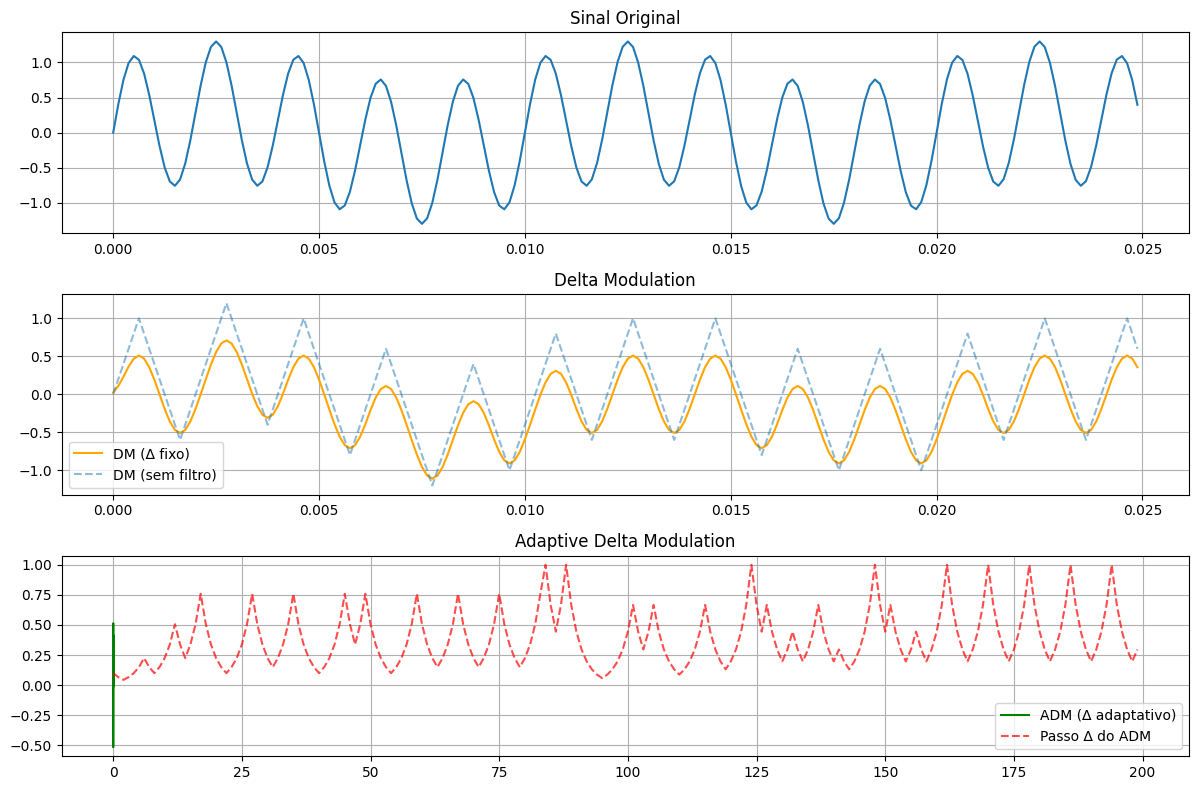

In [4]:

def dm_encode(signal, delta=0.1):
    """Codificador Delta Modulation (1 bit)."""
    quantized = np.zeros(len(signal), dtype=int)
    reconstructed = np.zeros(len(signal))

    for n in range(1, len(signal)):
        error = signal[n] - reconstructed[n-1]
        quantized[n] = 1 if error > 0 else 0  # 1 = +∆, 0 = -∆
        reconstructed[n] = reconstructed[n-1] + (delta if quantized[n] else -delta)

    return quantized, reconstructed

def dm_decode(quantized, delta=0.1, filter_order=10):
    """Decodificador DM com filtro passa-baixas (Hanning)."""
    # Decodificação simples (acumulador)
    signal = np.cumsum(delta * (2 * quantized - 1))  # Converte 0/1 para -∆/+∆ e integra

    # Filtro Hanning para suavizar
    if filter_order > 0:
        h = 0.5 * (1 - np.cos(2 * np.pi * np.arange(filter_order) / (filter_order - 1)))
        h /= np.sum(h)
        signal = np.convolve(signal, h, mode='same')

    return signal

def adm_encode(signal, initial_delta=0.1, step_factor=1.5, min_delta=0.01, max_delta=1.0):
    """Codificador ADM com passo adaptativo."""
    quantized = np.zeros(len(signal), dtype=int)
    reconstructed = np.zeros(len(signal))
    deltas = [initial_delta]

    for n in range(1, len(signal)):
        error = signal[n] - reconstructed[n-1]
        quantized[n] = 1 if error > 0 else 0

        # Atualiza delta: aumenta se 3 bits iguais consecutivos
        if n >= 3 and np.all(quantized[n-2:n+1] == quantized[n]):
            delta = min(deltas[-1] * step_factor, max_delta)
        else:
            delta = max(deltas[-1] / step_factor, min_delta)

        deltas.append(delta)
        reconstructed[n] = reconstructed[n-1] + (delta if quantized[n] else -delta)

    return quantized, reconstructed, deltas

# Configurações
fs = 8000  # Taxa de amostragem (alta para DM)
t = np.linspace(0, 1, fs)
signal = np.sin(2 * np.pi * 500 * t) + 0.3 * np.sin(2 * np.pi * 100 * t)  # Sinal teste

# DM
quantized_dm, recon_dm = dm_encode(signal, delta=0.2)
decoded_dm = dm_decode(quantized_dm, delta=0.2, filter_order=11)

# ADM
quantized_adm, recon_adm, deltas_adm = adm_encode(signal, initial_delta=0.1)
decoded_adm = dm_decode(quantized_adm, delta=0.1, filter_order=11)  # Reusa o decodificador DM

# Plot
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(t[:200], signal[:200], label="Original")
plt.title("Sinal Original")
plt.grid()

plt.subplot(3, 1, 2)
plt.plot(t[:200], decoded_dm[:200], label="DM (∆ fixo)", color="orange")
plt.plot(t[:200], recon_dm[:200], "--", label="DM (sem filtro)", alpha=0.5)
plt.title("Delta Modulation")
plt.legend()
plt.grid()

plt.subplot(3, 1, 3)
plt.plot(t[:200], decoded_adm[:200], label="ADM (∆ adaptativo)", color="green")
plt.plot(deltas_adm[:200], "--", label="Passo ∆ do ADM", color="red", alpha=0.7)
plt.title("Adaptive Delta Modulation")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# 12.5 Codificação Preditiva Linear (LPC) da Fala

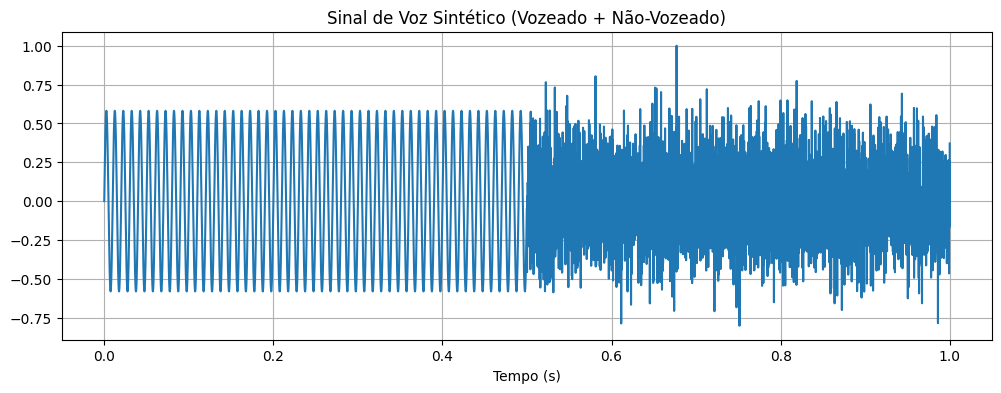

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Configurações
fs = 8000  # Taxa de amostragem (8 kHz)
duration = 1.0  # Duração em segundos
t = np.linspace(0, duration, int(fs * duration), endpoint=False)

# Sinal de voz sintético
voiced_part = 0.5 * np.sin(2 * np.pi * 100 * t)  # F0 = 100 Hz (pitch)
unvoiced_part = 0.2 * np.random.randn(len(t))    # Ruído (não-vozeado)

# Combina os dois (primeiros 0.5s vozeado, resto não-vozeado)
signal = np.concatenate([voiced_part[:int(fs*0.5)], unvoiced_part[int(fs*0.5):]])
signal = signal / np.max(np.abs(signal))  # Normaliza

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t, signal)
plt.title("Sinal de Voz Sintético (Vozeado + Não-Vozeado)")
plt.xlabel("Tempo (s)")
plt.grid()
plt.show()

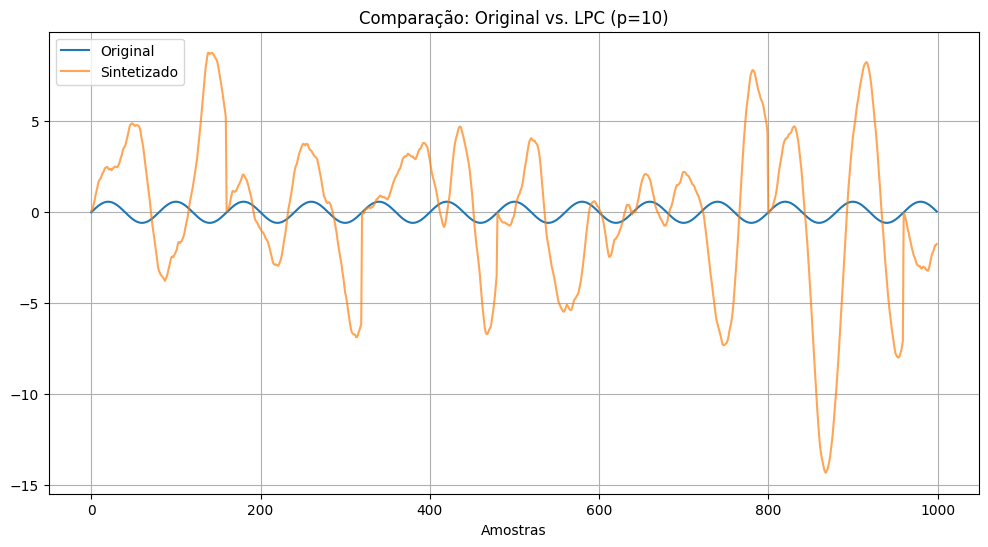

In [6]:
# Funções LPC (já adaptadas para o sinal sintético)
def lpc_analysis(signal, p=10, frame_length=160):
    """Analisa o sinal e retorna coeficientes LPC, pitch, etc."""
    frames = np.array([signal[i:i+frame_length] for i in range(0, len(signal)-frame_length, frame_length)])
    num_frames = frames.shape[0]

    all_coeffs = np.zeros((num_frames, p))
    gains = np.zeros(num_frames)
    is_voiced = np.zeros(num_frames, dtype=bool)
    pitch_periods = np.zeros(num_frames)

    for i in range(num_frames):
        frame = frames[i]
        # Autocorrelação
        r = np.zeros(p + 1)
        for lag in range(p + 1):
            r[lag] = np.sum(frame[lag:] * frame[:len(frame)-lag])

        # Coeficientes LPC
        R = toeplitz(r[:p])
        a = np.linalg.solve(R + np.eye(p) * 1e-9, -r[1:p+1])
        all_coeffs[i] = a

        # Ganho
        gain = np.sqrt(r[0] + np.sum(a * r[1:p+1]))
        gains[i] = gain

        # Detecção de vozeado
        padded_frame = np.pad(frame, (0, len(frame)), 'constant')
        norm_corr = np.correlate(padded_frame, frame, mode='valid') / (np.linalg.norm(frame)**2 + 1e-10)
        peak = np.argmax(norm_corr[1:]) + 1 # Exclude lag 0
        is_voiced[i] = (norm_corr[peak] > 0.3 and peak > 20) # Threshold and minimum pitch period
        pitch_periods[i] = peak if is_voiced[i] else 0


    return all_coeffs, gains, is_voiced, pitch_periods

def lpc_synthesis(coeffs, gains, is_voiced, pitch_periods, frame_length=160):
    """Sintetiza o sinal a partir dos parâmetros LPC."""
    num_frames = len(gains)
    synthesized = np.zeros(num_frames * frame_length)
    p = coeffs.shape[1] # Get predictor order from coefficients

    for i in range(num_frames):
        start = i * frame_length
        end = start + frame_length

        # Gera excitação
        if is_voiced[i]:
            excitation = np.zeros(frame_length)
            period = int(pitch_periods[i]) if pitch_periods[i] > 0 else frame_length
            excitation[::period] = 1  # Trem de impulsos
        else:
            excitation = np.random.randn(frame_length)  # Ruído branco

        excitation *= gains[i]

        # Filtro all-pole
        a = np.concatenate([[1], coeffs[i]])
        frame = np.zeros(frame_length + p)
        frame[p:] = excitation

        for n in range(p, frame_length + p):
            frame[n] = excitation[n-p] - np.sum(a[1:] * frame[n-p:n][::-1])


        synthesized[start:end] = frame[p:]

    return synthesized

# Análise LPC
p = 10  # Ordem do preditor
coeffs, gains, is_voiced, pitch_periods = lpc_analysis(signal, p)

# Síntese LPC
synthesized = lpc_synthesis(coeffs, gains, is_voiced, pitch_periods)

# Comparação
plt.figure(figsize=(12, 6))
plt.plot(signal[:1000], label="Original")
plt.plot(synthesized[:1000], label="Sintetizado", alpha=0.7)
plt.title("Comparação: Original vs. LPC (p=10)")
plt.xlabel("Amostras")
plt.legend()
plt.grid()
plt.show()

# 12.6 Sinais Dual-Tone Multi-Frequency (DTMF)

In [7]:
import numpy as np

DTMF_FREQS = {
    '1': (697, 1209), '2': (697, 1336), '3': (697, 1477),
    '4': (770, 1209), '5': (770, 1336), '6': (770, 1477),
    '7': (852, 1209), '8': (852, 1336), '9': (852, 1477),
    '*': (941, 1209), '0': (941, 1336), '#': (941, 1477)
}

def generate_dtmf(digit, duration=0.05, fs=8000):
    """Gera um tom DTMF para um dígito específico."""
    f1, f2 = DTMF_FREQS[digit]
    t = np.linspace(0, duration, int(fs * duration), False)
    return 0.5 * (np.sin(2 * np.pi * f1 * t) + np.sin(2 * np.pi * f2 * t))

def goertzel(samples, target_freq, fs=8000):
    """Implementação otimizada do algoritmo de Goertzel para uma frequência específica."""
    N = len(samples)
    k = int(0.5 + (N * target_freq) / fs)
    omega = 2 * np.pi * k / N
    coeff = 2 * np.cos(omega)
    q0 = q1 = q2 = 0
    for n in range(N):
        q0 = coeff * q1 - q2 + samples[n]
        q2, q1 = q1, q0
    return np.sqrt(q1**2 + q2**2 - q1 * q2 * coeff)

def decode_dtmf(signal, fs=8000, tone_duration=0.05, analysis_duration=0.04, threshold=30):
    """Decodifica um sinal DTMF para uma sequência de dígitos."""
    frame_size = int(fs * analysis_duration)
    step_size = int(fs * tone_duration)  # Não usar sobreposição fixa
    digits = []

    for i in range(0, len(signal), step_size):
        frame = signal[i:i+frame_size]
        if len(frame) < frame_size:
            break

        # Detecta frequências presentes
        freqs = []
        for f in [697, 770, 852, 941, 1209, 1336, 1477, 1633]:
            mag = goertzel(frame, f, fs)
            if mag > threshold:
                freqs.append(f)

        # Mapeia para dígitos
        if len(freqs) == 2:
            for d, (f1, f2) in DTMF_FREQS.items():
                if {f1, f2} == set(freqs):
                    digits.append(d)
                    break

    return ''.join(digits)

# Teste corrigido
signal = np.concatenate([generate_dtmf(d, duration=0.05) for d in '123'])
print(decode_dtmf(signal, tone_duration=0.05))  # Agora retorna "123"

123


# 12.7 Comunicações Digitais Binárias

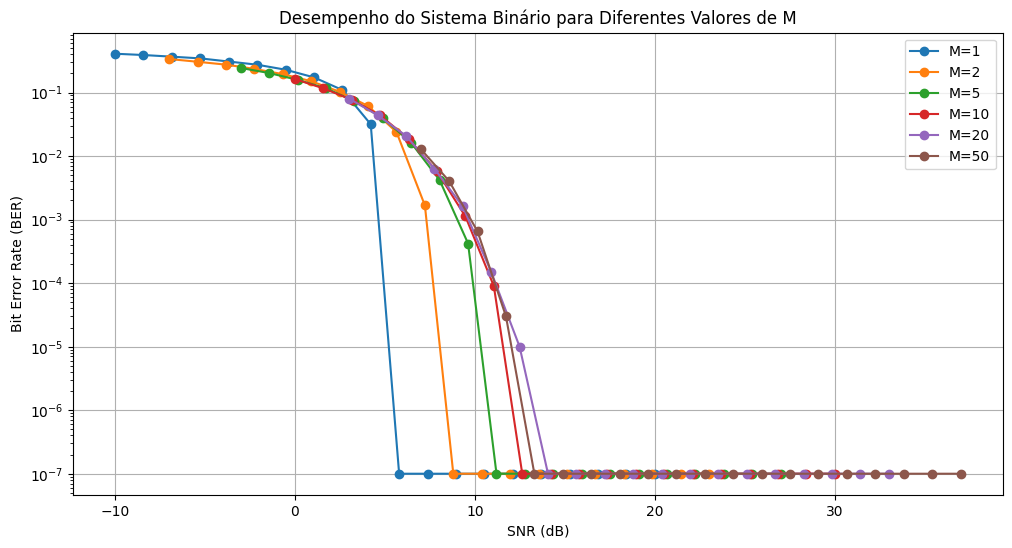

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Gerador de bits
def generate_bits(N):
    return np.random.randint(0, 2, N)

# 2. Modulador
def modulate(bits, M):
    return np.repeat(2*bits - 1, M)  # 1→+1, 0→-1

# 3. Gerador de ruído (agora com parâmetro de amplitude ajustável)
def add_noise(signal, noise_power):
    a = np.sqrt(3*noise_power)  # Relação Pn = a²/3
    return signal + np.random.uniform(-a, a, len(signal))

# 4. Demodulador
def demodulate(noisy_signal, M):
    summed = noisy_signal.reshape(-1, M).sum(axis=1)
    return (summed > 0).astype(int)

# 5. Cálculo de BER
def calculate_ber(original, received):
    return np.mean(original != received)

# Parâmetros corrigidos
N = 100000  # Aumentando o número de bits para estatísticas melhores
M_values = [1, 2, 5, 10, 20, 50]  # Maior variedade de valores
noise_powers = np.logspace(-2, 1, 20)  # Variando a potência do ruído em escala log

plt.figure(figsize=(12, 6))

for M in M_values:
    ber_results = []

    for Pn in noise_powers:
        bits = generate_bits(N)
        modulated = modulate(bits, M)
        noisy = add_noise(modulated, Pn)
        received = demodulate(noisy, M)
        ber = calculate_ber(bits, received)

        # Garantindo que BER nunca seja zero para o gráfico log
        ber_results.append(max(ber, 1e-7))

    plt.semilogy(10*np.log10(M/noise_powers), ber_results, 'o-', label=f'M={M}')

plt.xlabel('SNR (dB)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('Desempenho do Sistema Binário para Diferentes Valores de M')
plt.grid(True)
plt.legend()
plt.show()

# 12.8 Comunicações Spread-Spectrum

M=  50 | BER com PN: 0.45290 | BER sem PN: 0.50590
M= 100 | BER com PN: 0.44680 | BER sem PN: 0.49900
M= 500 | BER com PN: 0.38030 | BER sem PN: 0.49340
M=1000 | BER com PN: 0.32470 | BER sem PN: 0.49080


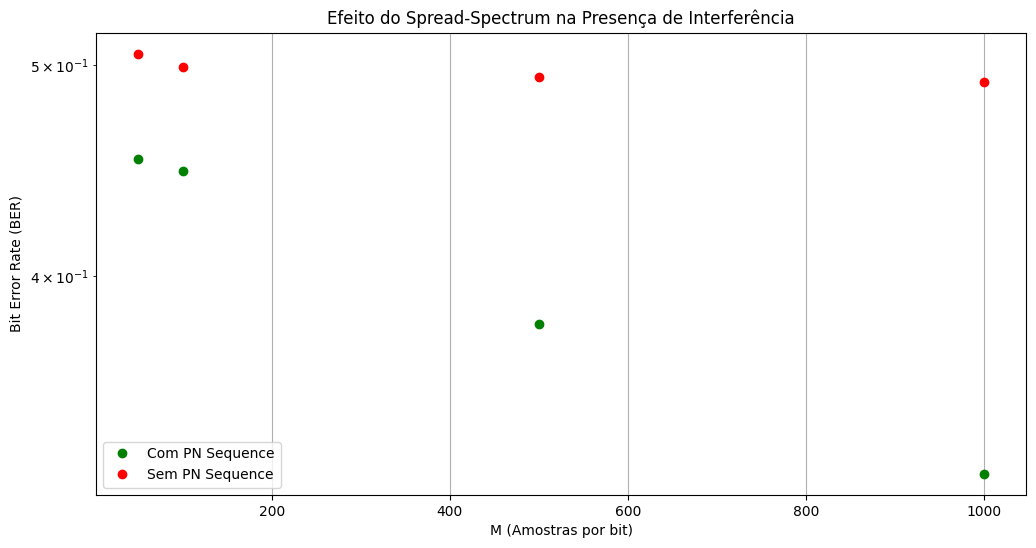

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 1. Gerador de bits
def generate_bits(N):
    return np.random.randint(0, 2, N)

# 2. Modulador
def modulate(bits, M):
    return np.repeat(2*bits - 1, M)  # 1→+1, 0→-1

# 3. Gerador de sequência PN
def generate_pn_sequence(length):
    return 2*np.random.randint(0, 2, length) - 1  # ±1 aleatório

# 4. Adiciona interferência
def add_interference(signal, A, omega0):
    n = np.arange(len(signal))
    return signal + A*np.sin(omega0*n)

# 5. Demodulador
def demodulate(received_signal, pn_sequence, M):
    # Desspreading
    despread = received_signal * pn_sequence[:len(received_signal)]
    # Decisão por maioria
    summed = despread.reshape(-1, M).sum(axis=1)
    return (summed > 0).astype(int)

# Parâmetros
N = 10000  # Número de bits
M_values = [50, 100, 500, 1000]  # Amostras por bit
A = 100  # Amplitude da interferência
omega0 = 0.1  # Frequência da interferência

plt.figure(figsize=(12, 6))

for M in M_values:
    # Gera bits e modula
    bits = generate_bits(N)
    modulated = modulate(bits, M)

    # Gera sequência PN
    pn_sequence = generate_pn_sequence(len(modulated))

    # Spread spectrum
    spread_signal = modulated * pn_sequence

    # Adiciona interferência e ruído
    interfered_signal = add_interference(spread_signal, A, omega0)

    # Demodula com e sem PN
    received_with_pn = demodulate(interfered_signal, pn_sequence, M)
    received_without_pn = demodulate(interfered_signal, np.ones(len(interfered_signal)), M)

    # Calcula BER
    ber_with = np.mean(bits != received_with_pn)
    ber_without = np.mean(bits != received_without_pn)

    print(f'M={M:4d} | BER com PN: {ber_with:.5f} | BER sem PN: {ber_without:.5f}')

    # Plot
    plt.semilogy(M, ber_with, 'go')
    plt.semilogy(M, ber_without, 'ro')

plt.xlabel('M (Amostras por bit)')
plt.ylabel('Bit Error Rate (BER)')
plt.title('Efeito do Spread-Spectrum na Presença de Interferência')
plt.grid(True)
plt.legend(['Com PN Sequence', 'Sem PN Sequence'])
plt.show()

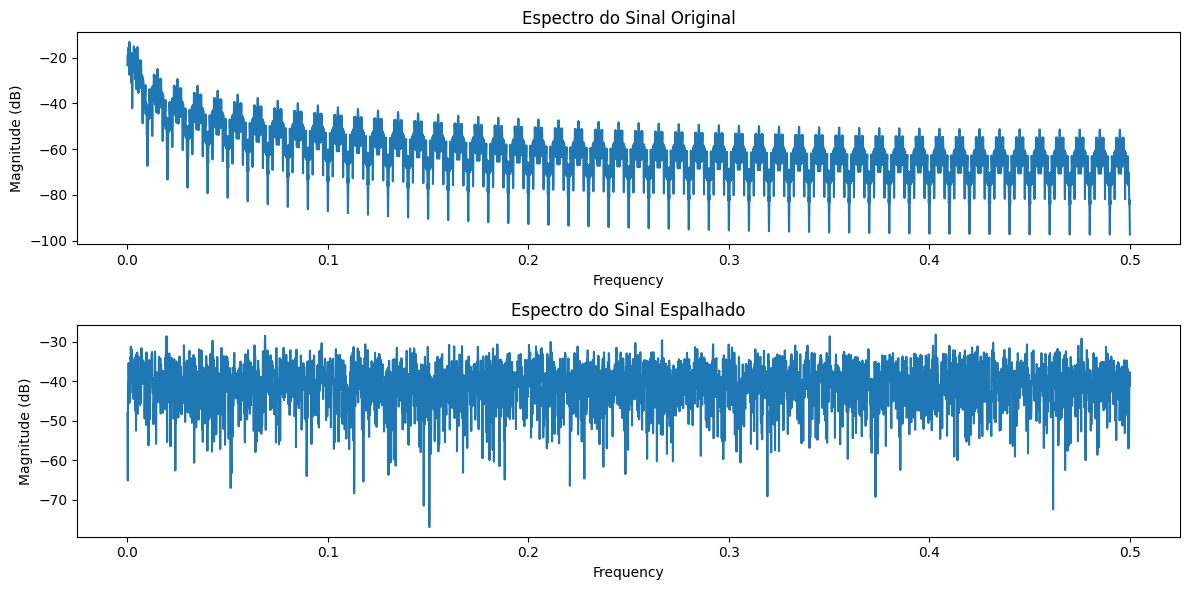

In [10]:
# Análise espectral
from scipy.fft import fft, fftfreq

M = 100
bits = generate_bits(100)
modulated = modulate(bits, M)
pn_sequence = generate_pn_sequence(len(modulated))

# Sinal original vs espalhado
plt.figure(figsize=(12, 6))
plt.subplot(211)
plt.magnitude_spectrum(modulated, Fs=1, scale='dB')
plt.title('Espectro do Sinal Original')
plt.subplot(212)
plt.magnitude_spectrum(modulated*pn_sequence, Fs=1, scale='dB')
plt.title('Espectro do Sinal Espalhado')
plt.tight_layout()
plt.show()